# Introduction

---

Notebook ini ditujukan untuk seleksi Asisten Lab GaIB, berisikan code end-to-end machine learning untuk mengklasifikasi teks (emotion classification)

Link spesifikasi: bit.ly/seleksiGaIB2024


Author: <br>
Novelya Putri Ramadhani 13522096 <br>

# Table Of Contents

**I. Introduction** <br>
**II. Import Libraries** <br>
**III. Exploratory Data Analysis** <br>
- Load and Preview the Dataset
- Dataset Overview
- Descriptive Statistics
- Data Distribution

**IV. Data Preprocessing** <br>
- Data Cleaning
    - Remove Duplicates
- Data Transformation
    - Handling Abbreviations

**V. Modeling and Validation** <br>
- Data Splitting
- TF-IDF Vectorization
- Model Training
- Model Prediction
- Model Evaluation

# Import Libraries

In [24]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

## Load and Preview the Dataset

In [25]:
data = pd.read_csv('../dataset/Twitter_Emotion_Dataset.csv')

In [26]:
kamus = pd.read_csv('../dataset/kamus_singkatan.csv')

In [27]:
data.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [28]:
kamus.head()

,aamiin;amin
0,adek;adik
1,adlh;adalah
2,aer;air
3,aiskrim;es krim
4,aj;saja


## Dataset Overview

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4401 non-null   object
 1   tweet   4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [30]:
kamus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   aamiin;amin   1308 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB


In [31]:
# Check for missing values
data.isnull().sum()

label    0
tweet    0
dtype: int64

Tidak ada missing value pada dataset ini sehingga tidak perlu dilakukan handling missing value.

In [32]:
# Check for duplicate values
data.duplicated().sum()

np.int64(11)

Terdapat duplikat data pada dataset ini, sehingga perlu dilakukan handling duplikat data.

## Descriptive Statistics

In [33]:
# Check for unique values in the label column
n_emo = data["label"].value_counts()
n_emo

label
anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: count, dtype: int64

In [34]:
# Display basic statistics about tweet lengths
tweet_lengths = data['tweet'].apply(len)
tweet_lengths.describe()

count    4401.000000
mean      182.352193
std        55.697054
min        12.000000
25%       147.000000
50%       178.000000
75%       226.000000
max       500.000000
Name: tweet, dtype: float64

## Data Distribution

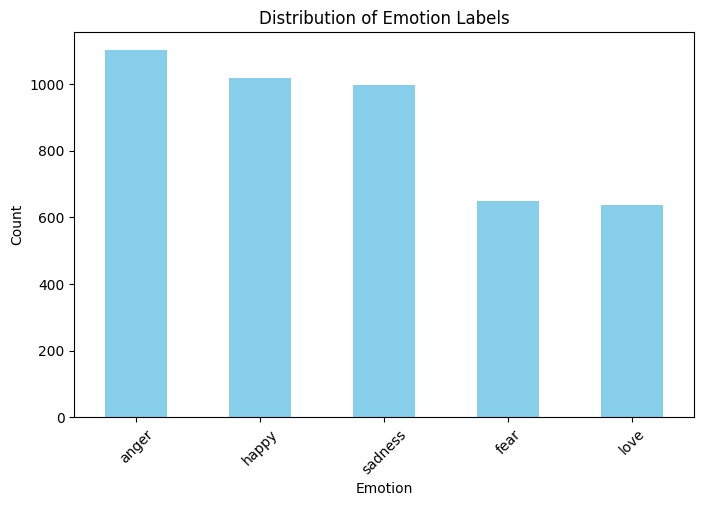

In [35]:
# Plot the distribution of emotion labels
plt.figure(figsize=(8,5))
n_emo.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Dataset terdiri dari beberapa emosi, dengan beberapa emosi terjadi lebih sering daripada yang lain.

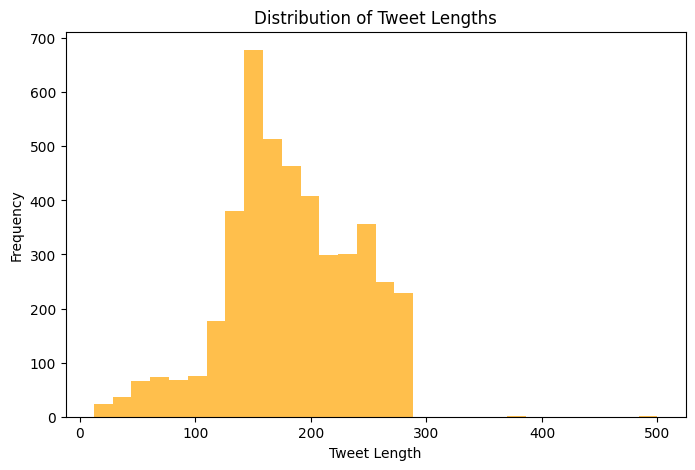

In [36]:
# Plot the distribution of tweet lengths
plt.figure(figsize=(8,5))
plt.hist(tweet_lengths, bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

Kebanyakan tweet memiliki panjang antara 100 hingga 250 karakter, dengan rata-rata panjang tweet sebesar 182 karakter. Panjang tweet maksimum adalah 500, sedangkan yang terpendek adalah 12 karakter.

# Data Preprocessing

## Data Cleaning

### Remove Duplicates

Terdapat duplikasi pada data yang dapat menyebabkan model memberikan bias yang tidak diinginkan, sehingga menghapusnya membantu memastikan bahwa setiap observasi dalam data adalah unik.

In [37]:
print(f"Before removing duplicates: {data.shape}")
data = data.drop_duplicates()
print(f"After removing duplicates: {data.shape}")

Before removing duplicates: (4401, 2)
After removing duplicates: (4390, 2)


## Data Transformation

### Handling Abbreaviations

In [38]:
abbreviation_df = kamus[kamus.columns[0]].str.split(';', expand=True)
abbreviation_df.columns = ['abbreviation', 'full_form']

# Create a dictionary from the corrected abbreviation dataset
abbreviation_dict = pd.Series(abbreviation_df['full_form'].values, index=abbreviation_df['abbreviation']).to_dict()

# Function to replace abbreviations
def replace_abbreviations(text, abbrev_dict):
    words = text.split()
    return ' '.join([abbrev_dict.get(word.lower(), word) for word in words])

# Preprocessing function for tweets (lowercase, replace abbreviations, and remove special characters)
def preprocess_tweet(tweet):
    # Replace abbreviations
    tweet = replace_abbreviations(tweet, abbreviation_dict)
    
    # Remove special characters and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    return tweet

# Apply preprocessing to the tweets
data['cleaned_tweet'] = data['tweet'].apply(preprocess_tweet)

# Display the first few rows after preprocessing
data[['tweet', 'cleaned_tweet']].head()

,tweet,cleaned_tweet
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibarupolisi tidak bisa gertak g...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek lho kayaknya harusnya bisa lebih...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibarubagian dari wilayah tn abangpen...
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam batalin ti...


# Modeling and Validation

## Data Splitting

In [39]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_tweet'], data['label'], test_size=0.2, random_state=42)

## TF-IDF Vectorization

TF-IDF (Term Frequency - Inverse Document Frequency) digunakan untuk mengubah teks menjadi bentuk numerik yang dapat digunakan oleh algoritma machine learning. TF-IDF menurunkan bobot kata-kata yang sering muncul di seluruh dokumen (misalnya "dan", "di") dan memberikan bobot lebih tinggi pada kata-kata yang jarang namun penting untuk membedakan konteks. Ini membantu model memahami kata-kata yang lebih relevan dalam teks, sehingga lebih efektif dalam melakukan klasifikasi. TF-IDF juga menghasilkan representasi numerik dari teks yang siap digunakan oleh model seperti Logistic Regression.

In [40]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Model Training

Logistic Regression digunakan karena model ini sederhana, cepat, dan efektif dalam menangani masalah klasifikasi, termasuk teks. Model ini cocok untuk memproses vektor yang dihasilkan oleh TF-IDF dan memberikan hasil yang mudah diinterpretasikan, membantu memahami hubungan antara kata-kata dan emosi yang diprediksi.

In [41]:
# Build and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

## Model Prediction

In [42]:
# Predict and evaluate the model
y_pred = clf.predict(X_test_tfidf)

## Model Evaluation

In [45]:
# Display the classification report
classification_report_output = classification_report(y_test, y_pred)
print(classification_report_output)

              precision    recall  f1-score   support

       anger       0.61      0.74      0.67       218
        fear       0.81      0.55      0.65       129
       happy       0.63      0.62      0.62       211
        love       0.85      0.73      0.79       127
     sadness       0.52      0.56      0.54       193

    accuracy                           0.64       878
   macro avg       0.68      0.64      0.65       878
weighted avg       0.66      0.64      0.64       878

